<a href="https://colab.research.google.com/github/nahumsa/Aprendendo-Go/blob/master/Masked%20Language%20Modeling%20with%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Masked Language modeling with BERT

[source](https://keras.io/examples/nlp/masked_language_modeling/) [additional reference](https://towardsdatascience.com/transformers-explained-visually-part-2-how-it-works-step-by-step-b49fa4a64f34)

A masked language modeling fills a blank on a given text, just like a auto-completer. For example:

- Input: "I would [MASK] to eat."
- Output: "I would like to eat."

Masked language modeling are a good way to train a language model in a self-supervised setting, and then fine-tuned to acomplish supervised NLP tasks.

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from dataclasses import dataclass

# Configuration

In [2]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30_000
    EMBED_DIM = 128
    NUM_HEAD = 8 
    FF_DIM = 128
    NUM_LAYERS = 1

config = Config()

# Loading the data

In [3]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  13.7M      0  0:00:05  0:00:05 --:--:-- 19.6M


In [4]:
def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list

def get_data_from_text_files(folder_name):
    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df

train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = train_df.append(test_df)

# Preparing the data

We will use `TextVectorization` to vectorize the text into integer token ids.

In [5]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )

def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """ Build text vectorization layer

    Args:
        texts (list): List of string i.e. input texts.
        vocab_size (int): vocabulary size
        max_seq (int): Maximum sequence lenght.
        special_tokens (list, optional): List of special tokens.
        Default = ["[MASK]"]
    
    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )

    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"] # maybe special_tokens
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

#get mask token id
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]
print("Mask token:", mask_token_id)

Mask token: 29999


In [6]:
def encode(texts) -> np.array:
    """ Encode texts using the vectorize_layer.

    """
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

def get_masked_input_and_labels(encoded_texts):

    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [mask] which is the last token of the 90% of tokens
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.9)
    encoded_texts_masked [ inp_mask_2mask ] = mask_token_id 
    # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (
        np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to a .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

# 2500 training examples
x_train = encode(train_df.review.values)
y_train = train_df.sentiment.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# 2500 testing examples
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)


# Build dataset for end-to-end model
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)

# Prepare data for masked language model
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)

mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

# Create BERT model

In [7]:
def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name=f"encoder_{i}/multiheadattention"
    )(query, key, value)

    attention_output = layers.Dropout(0.1,
                                      name=f"encoder_{i}/att_dropout")(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}/att_layernormalization"
    )( query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
         layers.Dense(config.FF_DIM, activation='relu'),
         layers.Dense(config.EMBED_DIM),
        ],
        name=f"encoder_{i}/ffn",
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
    )(attention_output + ffn_output)
    return sequence_output

def get_pos_encoding_matrix(max_len, d_emb):
    """ Positional encoding matrix for the transformer model
    """
    pos_enc = np.array(
        [
         [pos / np.power(10_000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
         if pos != 0
         else np.zeros(d_emb)
         for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return pos_enc

loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE,
)
loss_tracker = tf.keras.metrics.Mean(name="loss")

In [8]:
class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            feature, labels = inputs
            sample_weight = None
        
        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weight
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # return a dict mapping metric
        return {"loss": loss_tracker.result()}
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]


In [9]:
def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position embedding",
    )( tf.range(start=0, limit=config.MAX_LEN, delta=1))
    
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings

    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output,
                                     encoder_output,
                                     encoder_output,
                                     i)
    
    mlm_output = layers.Dense(config.VOCAB_SIZE,
                              name="mlm_cls",
                              activation="softmax")(encoder_output)
    mlm_model = MaskedLanguageModel(inputs,
                                    mlm_output,
                                    name="masked_bert_model")
    
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model

id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x,y in id2token.items()}

class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k
    
    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])
    
    def convert_ids_to_tokens(self, id):
        return id2token[id]
    
    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[- self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            print(result)

sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 256, 128)     3840000     input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 256, 128)     0           word_embedding[0][0]             
__________________________________________________________________________________________________
encoder_0/multiheadattention (M (None, 256, 128)     66048       tf.__operators__.add[0][0]       
                                                                 tf.__operators__.

# Train and save

In [10]:
history = bert_masked_model.fit(mlm_ds,
                                epochs=5,
                                callbacks=[generator_callback]
                                )

bert_masked_model.save("bert_mlm_imdb.h5")

Epoch 1/5
1563/1563 [==============================] - 441s 279ms/step - loss: 7.0051
{'input_text': 'i have watched this [mask] and it was awesome', 'prediction': 'i have watched this i and it was awesome', 'probability': 0.09980429, 'predicted mask token': 'i'}
{'input_text': 'i have watched this [mask] and it was awesome', 'prediction': 'i have watched this this and it was awesome', 'probability': 0.06419232, 'predicted mask token': 'this'}
{'input_text': 'i have watched this [mask] and it was awesome', 'prediction': 'i have watched this movie and it was awesome', 'probability': 0.031219937, 'predicted mask token': 'movie'}
{'input_text': 'i have watched this [mask] and it was awesome', 'prediction': 'i have watched this it and it was awesome', 'probability': 0.029675052, 'predicted mask token': 'it'}
{'input_text': 'i have watched this [mask] and it was awesome', 'prediction': 'i have watched this a and it was awesome', 'probability': 0.029391544, 'predicted mask token': 'a'}
Epoch

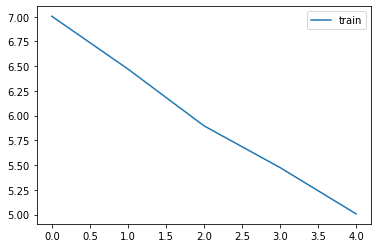

In [11]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']

epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label="train")
plt.legend()
plt.show()

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
! mv -f bert_mlm_imdb.h5 gdrive/MyDrive/

# Sentiment analysis using BERT

In [ ]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.h5", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0/ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False

def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model

classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Train the classifier with frozen BERT stage
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

# Unfreeze the BERT model for fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

history = classifer_model.fit(
                              train_classifier_ds,
                              epochs=5,
                              validation_data=test_classifier_ds,
                            )

Model: "classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
model_1 (Functional)         (None, 256, 128)          3939584   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 3,947,905
Trainable params: 8,321
Non-trainable params: 3,939,584
_________________________________________________________________
Epoch 1/5
782/782 [==============================] - 13s 16ms/step - loss: 0.7265 - accuracy: 0.5684 - v

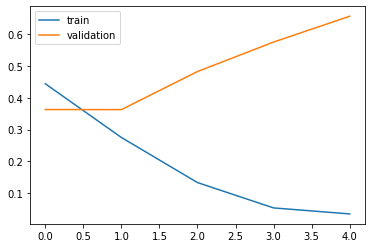

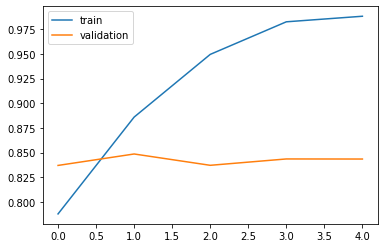

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label="train")
plt.plot(epochs, val_loss, label="validation")
plt.legend()
plt.show()

epochs = range(len(train_loss))
plt.plot(epochs, train_accuracy, label="train")
plt.plot(epochs, val_accuracy, label="validation")
plt.legend()
plt.show()

In [ ]:
def get_end_to_end(model):
    inputs_string = keras.Input(shape=(1,), dtype="string")
    indices = vectorize_layer(inputs_string)
    outputs = model(indices)
    end_to_end_model = keras.Model(inputs_string, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


end_to_end_classification_model = get_end_to_end(classifer_model)
end_to_end_classification_model.evaluate(test_raw_classifier_ds)

782/782 [==============================] - 9s 11ms/step - loss: 0.6788 - accuracy: 0.8397


[0.6787503361701965, 0.839680016040802]